In [2]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np

In [3]:
# 定义超参数
input_size = 2
# 隐藏层大小，一般为输入特征的2~4倍
hidden_size = 64
# LSTM层数，较深的网络可能更能够捕捉序列中的长期依赖关系，但也会增加训练时间和计算成本。
# 通常建议使用 1-3 层 LSTM，具体取决于数据集和问题复杂度。
num_layers = 1
output_size = 1
batch_size = 32
# 通常建议使用较小的学习率（例如 0.001）进行初始训练，然后根据模型在验证集上的性能进行微调。
learning_rate = 0.002
num_epochs = 10

In [4]:
class MyDataset(Dataset):
    def __init__(self, data_path, sequence_length):
        self.data = pd.read_csv(data_path)
        self.sequence_length = sequence_length
        self.features = self.data.drop(['write_counts'], axis=1).values.astype(np.float32)
        self.targets = self.data['write_counts'].values.astype(np.float32)
    
    def __len__(self):
        return len(self.data) - self.sequence_length
    
    def __getitem__(self, idx):
        start_idx = idx
        end_idx = idx + self.sequence_length
        x = self.features[start_idx:end_idx]
        y = self.targets[end_idx]
        return x, y

In [5]:
""" 
一般情况下，LSTM 模型的输入应该是一个 3 维张量，其维度为 [batch_size, sequence_length, input_size]，
分别表示批次大小、时间序列长度和输入维度。因此，在处理数据集时，需要将原始数据转换成这种形式。
"""
class MyLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(MyLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        # 将输入的形状从 [batch_size * sequence_length, input_size] 转换为 [batch_size, sequence_length, input_size]
        # batch_size = x.size(0) // self.num_layers
        # x = x.view(batch_size, -1, self.lstm.input_size)

        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = out[:, -1, :]
        out = self.fc(out)
        return out

In [6]:
# 训练集路径
train_data_path = "./dataset/btcusd_low.csv"
train_ratio = 0.8

In [25]:
# 加载数据集
dataset = MyDataset(train_data_path, sequence_length=32)
train_size = int(len(dataset) * train_ratio)
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

# 加载数据并训练模型
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [26]:
# 定义模型、损失函数和优化器
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MyLSTM(input_size, hidden_size, num_layers, output_size)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [27]:
for epoch in range(num_epochs):
    for i, (inputs, targets) in enumerate(train_loader):
        inputs = inputs.float()
        targets = targets.float()
        
        # 前向传播
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        
        # 反向传播和优化
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 200 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                  .format(epoch+1, num_epochs, i+1, len(train_loader), loss.item()))

Epoch [1/10], Step [200/750], Loss: 21.6599
Epoch [1/10], Step [400/750], Loss: 8.0286
Epoch [1/10], Step [600/750], Loss: 6.1048


/home/jason/.local/lib/python3.8/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([6])) that is different to the input size (torch.Size([6, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [2/10], Step [200/750], Loss: 7.1138
Epoch [2/10], Step [400/750], Loss: 5.8082
Epoch [2/10], Step [600/750], Loss: 4.7360
Epoch [3/10], Step [200/750], Loss: 5.5644
Epoch [3/10], Step [400/750], Loss: 4.0381
Epoch [3/10], Step [600/750], Loss: 4.1707
Epoch [4/10], Step [200/750], Loss: 4.2916
Epoch [4/10], Step [400/750], Loss: 5.1890
Epoch [4/10], Step [600/750], Loss: 4.2256
Epoch [5/10], Step [200/750], Loss: 3.7514
Epoch [5/10], Step [400/750], Loss: 5.9409
Epoch [5/10], Step [600/750], Loss: 5.3519
Epoch [6/10], Step [200/750], Loss: 3.2567
Epoch [6/10], Step [400/750], Loss: 4.0909
Epoch [6/10], Step [600/750], Loss: 5.9065
Epoch [7/10], Step [200/750], Loss: 4.3716
Epoch [7/10], Step [400/750], Loss: 4.5430
Epoch [7/10], Step [600/750], Loss: 4.5253
Epoch [8/10], Step [200/750], Loss: 3.3472
Epoch [8/10], Step [400/750], Loss: 5.8475
Epoch [8/10], Step [600/750], Loss: 4.3181
Epoch [9/10], Step [200/750], Loss: 7.0062
Epoch [9/10], Step [400/750], Loss: 5.3414
Epoch [9/10

In [28]:
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for inputs, targets in test_loader:
        inputs = inputs.float()
        targets = targets.float()

        outputs = model(inputs)
        predicted = torch.squeeze(torch.round(outputs))
        total += targets.size(0)
        temp = predicted == targets
        correct += temp.sum().item()

    accuracy = 100 * correct / total
    print('Accuracy of the model on the test dataset: {:.2f} %'.format(accuracy))

Accuracy of the model on the test dataset: 16.23 %


In [44]:
print(train_dataset.dataset.data.head())


      read_time  write_counts   period
0  1.364778e+12           6.0      0.0
1  1.364780e+12           5.0   2580.0
2  1.364785e+12           3.0   4560.0
3  1.364797e+12           5.0  12660.0
4  1.364811e+12           6.0  13320.0


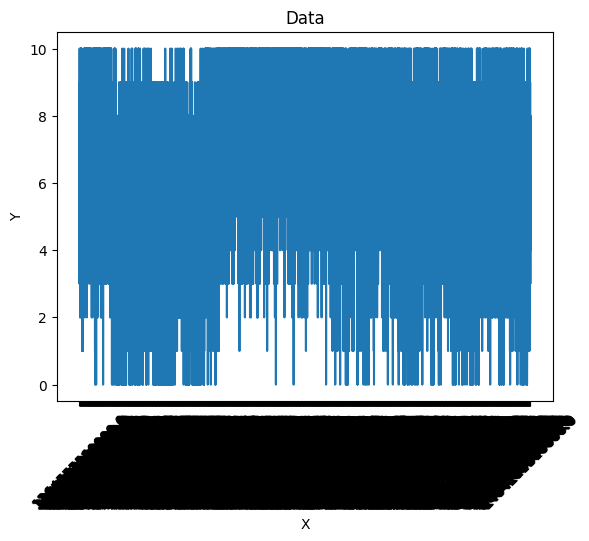